# Evaluation of solutions

This notebook provides commands used in constructing a smoothed estimate of mutation density using wavelet decomposition (described in Section S4), and simulating the distribution of the number of recurrent mutations (using Algorithm 1).

External tools used:

[MAFFT](https://mafft.cbrc.jp/alignment/software/)

[SNP-sites](https://www.sanger.ac.uk/tool/snp-sites/)

The list of problematic sites to mask by De Maio et al. (2020) is downloaded as `problematic_sites_sarsCov2.vcf` from [here](https://github.com/W-L/ProblematicSites_SARS-CoV2) (using update to 4 March 2021).

## Data processing

Data from [GISAID](https://www.gisaid.org/) was downloaded on 13 April 2021, filtering for sequences:

- collected between 1 and 3 February 2021 (all countries);

- marked as complete (>29,900 nucleotides), high coverage and excluding low coverage sequences (>5% ambiguous nucleotides);

giving 17,908 sequences in total. Alignment to the reference sequence (GISAID accession EPI_ISL_402125, GenBank ID MN908947.3) was done using MAFFT with the options
```sh
--auto --thread -1 --keeplength ---preservecase --addfragments
```
The resulting multiple alignment file is named  `all_alignment.fasta`.

In [1]:
!seqkit stats all_alignment.fasta

file                 format  type  num_seqs      sum_len  min_len  avg_len  max_len
all_alignment.fasta  FASTA   DNA     17,908  535,502,924   29,903   29,903   29,903


The SNPs were extracted in vcf format using SNP-Sites, and the R script `positions.R` was used to output just the SNP positions to the file `all_positions.txt`:

In [2]:
!snp-sites -v -o all_snp.vcf all_alignment.fasta

In [3]:
!Rscript positions.R all_snp.vcf all_positions.txt

The number of variable sites is given by:

In [4]:
!wc -w < all_positions.txt

   13747


We also prepare the reference sequence stored in `ref_seq.fasta` for reading into R:

In [5]:
!awk '/^>/ { print (NR==1 ? "" : RS) $0; next } { printf "%s", $0 } END { printf RS }' ref_seq.fasta > ref_test.txt;
!sed -i .bak 's/./& /g' ref_test.txt;
!sed -i .bak 1d ref_test.txt

## Estimation of mutation density

The resulting list of positions is then read into R, and the vector $\overline{P}$ is created as follows.

In [1]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(data.table)))

f <- "all_positions.txt"
snp <- data.table(t(read.table(f, header=FALSE, fill=TRUE, row.names=NULL, sep = " "))) %>%
  rename(position = V1) %>%
  mutate(mut = 1)
filler <- data.frame(position = 1:29903)
snp <- right_join(snp, filler)
snp$mut[is.na(snp$mut)] <- 0

Joining, by = "position"



In [2]:
length(snp$mut)

[1] 29903

In [3]:
sum(snp$mut==1)

[1] 13747

The wavelet decomposition is performed using the `wavethresh` package. The thresholding is carried out using the `EbayesThresh` package which implements the method of Johnstone and Silverman (2005).

First we mask the necessary sites:

In [4]:
vcf <- fread("problematic_sites_sarsCov2.vcf", check.names=TRUE, skip="#CHROM")
mask <- c(vcf$POS)
# Additional sites to mask, from van Dorp et al. (2020, Supplementary Table S5):
# https://doi.org/10.1016/j.meegid.2020.104351
homoplasic <- c(11083,13402,21575,16887,27384,3037,25563,8782,10323,11074,14408,6255,12880,21137,1059,1820,1912,6040,15324,29353,14805,15720,18060,28077,28826,28887,29253,29553,29700,6310,6312,11704,14786,17747,18756,20148,22661,23010,23403,29095,29422,3177,4084,6990,8078,11916,14724,14925,17247,18788,18877,20755,21648,24034,25947,26152,26461,27005,27046,27964,28881,29742,1457,4255,5784,7011,8293,8917,9223,10319,10507,11320,12781,13947,15760,16260,19684,22988,23422,24390,25916,26144,26530,26730,27525,28144,28311,28344,28851,28854,29751,379,541,833,884,1076,1570,1594,2113,3096,3253,3787,4113,4320,6573,7438,7765,10789,10851,11417,14747,15960,16762,17410,17639,17799,17858,18656,20031,20268,20275,21204,21707,23533,23587,24368,24389,24694,25494,25688,26211,26729,26735,28657,28688,28739,28857,28878,29540,29585,29734,313,490,1515,2455,2558,4809,6723,7479,8767,9477,9479,10097,10265,10450,11195,11801,13730,13929,14741,14912,15277,15927,16289,16381,17104,17373,17690,17944,18652,18713,18928,18998,19170,20931,23086,23707,23731,23929,24054,24862,25433,25572,25979,26124,26625,26936,27299,27635,27679,28580,28821,28836,28882,28883,29144,29635,29686)
mask <- c(mask, homoplasic)
mask <- unique(mask)

In [5]:
# Add bases from reference sequence
g <- data.frame(base = t(read.table("ref_test.txt", header=FALSE, fill=TRUE, row.names=NULL, sep = " ", colClasses="character"))) %>%
  mutate(position = 1:29903)
snp <- right_join(snp, g)

# Mask the sites
snp$mut[mask] <- NA

Joining, by = "position"



In [6]:
suppressWarnings(suppressMessages(library(wavethresh)))
suppressWarnings(suppressMessages(library(EbayesThresh)))

# Carry out the wavelet regression, splitting by base type
mut_probs <- data.frame(position = 1:29903, rate = rep(NA, 29903), base = as.character(snp$base), stringsAsFactors=FALSE)
for(b in c("A", "C", "G", "T")) {
  X <- snp$mut[snp$base == b]
  Xpos <- snp$position[snp$base == b]
  Xpos <- Xpos[!is.na(X)]
  X <- X[!is.na(X)]
  
  # Padding to make total length a power of 2
  # This is done by reflecting the data at the endpoints
  pow <- ceiling(log(length(X), base=2))
  ext_left <- floor((2^pow - length(X))/2)
  ext_right <- length(X) - ceiling((2^pow - length(X))/2) + 1
  Xf <- c(rev(X[1:ext_left]), X, rev(X[length(X):ext_right]))
  
  # Wavelets with empirical Bayes thresholding
  Y <- wd(Xf, filter.number=6, family="DaubLeAsymm")
  Y <- ebayesthresh.wavelet(Y, threshrule="soft")
  Y <- wr(Y)
  Y <- Y[(ext_left+1):(ext_left + length(X))]
  
  mut_probs$rate[mut_probs$position %in% Xpos] <- Y
}

In [7]:
mut_probs <- mut_probs %>%
  mutate(rate = ifelse(rate < 0, 0, rate),
         rate_norm = rate/sum(rate, na.rm=TRUE))

To plot the resulting estimate (recreating Figure 1):

Warning message:
“Removed 155 rows containing missing values (geom_path).”


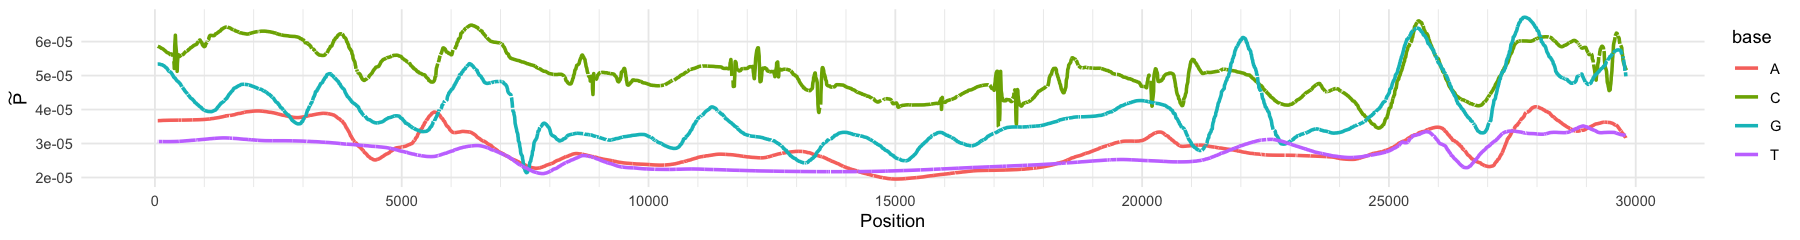

In [8]:
library(latex2exp)
options(repr.plot.width=15, repr.plot.height=2)

g3 <- ggplot(data=mut_probs, aes(x=position, y=rate_norm)) +
  geom_line(aes(colour = base), size=1) +
  theme_minimal() +
  xlab("Position") + 
  ylab(TeX("$\\widetilde{P}$")) +
  scale_x_continuous(breaks = seq(0,30000,5000), labels = seq(0,30000,5000), minor_breaks=seq(0,30000,1000)) +
  scale_y_continuous(breaks = seq(-0.00001,0.00007, 0.00001), labels = seq(-0.00001,0.00007, 0.00001), minor_breaks=NULL)
g3

The following functions implement Algorithm 1:

In [9]:
# Algorithm 1
sim <- function(M, m, P) {
  sites <- rep(NA, 10000)
  visited <- sample(1:M, size = m, replace=TRUE, prob=P)
  if(length(unique(visited)) == m) {
    return(m)
  }
  else {
    sites[1:m] <- visited
    for(i in (m+1):10000) {
      visited <- sample(1:M, size = 1, replace = TRUE, prob = P)
      sites[i] <- visited
      if(length(unique(sites[1:i])) == m) {
        return(i)
      }
    }
  }
}

calc <- function(M, m, n, P) {
  results <- rep(NA, n)
  for(i in 1:n) {
    results[i] <- sim(M, m, P)
  }
  return(results - m)
} 

This is used to simulate the distribution of the number of recurrent mutations as follows (the example here is shown for the South Africa dataset from November 2020).

In [10]:
Y <- mut_probs$rate_norm
Y[c(22266:22745, 28254)] <- NA # Masking additional sites
P <- Y[!is.na(Y)]
M <- length(P) # Length of the genome minus number of masked sites
print(M)
m <- 259 # Adjusted number of variable sites observed
res <- calc(M, m, 10000, P)

[1] 28777


To get a histogram of the results corresponding to the third column of Table 1a (run with 10,000 iterations in this case):

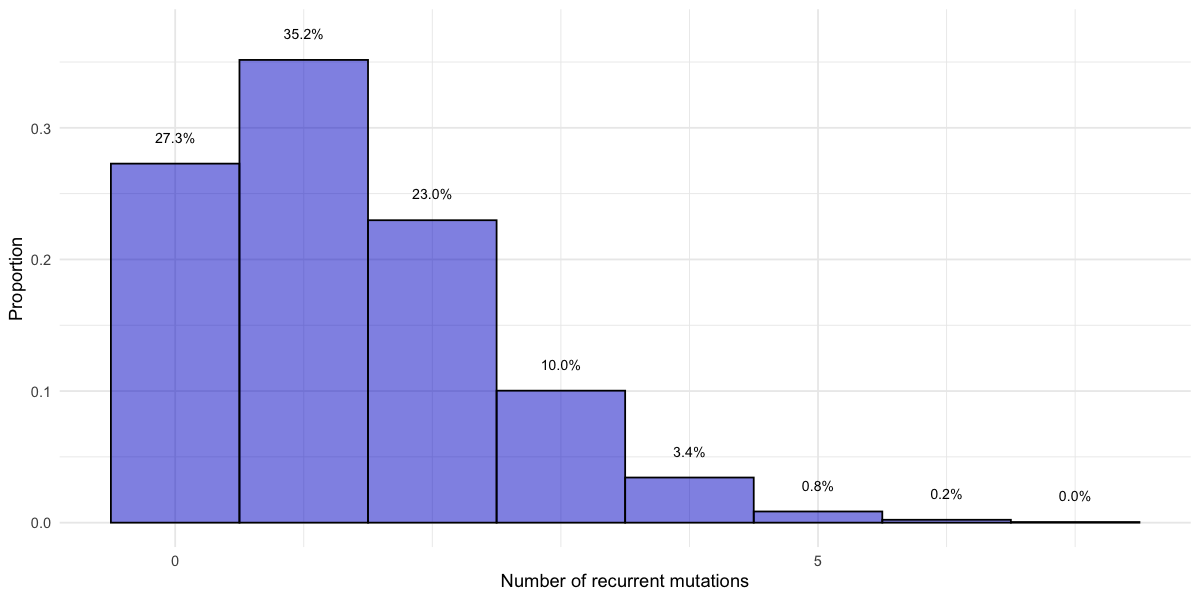

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
g3 <- ggplot(data.frame(x = res), aes(x=x)) + 
  geom_histogram(aes(y=..density..), binwidth=1, colour = "black", fill = "mediumblue", alpha = 0.5) +
  theme_minimal() +
  xlab("Number of recurrent mutations") +
  ylab("Proportion") +
  geom_text(aes( label = scales::percent(..prop.., accuracy = 0.1),
                 y= ..prop..), stat= "count", vjust = "middle", nudge_y=0.02, size=3) +
  scale_x_continuous(breaks = seq(0,15,5), labels = seq(0,15,5), minor_breaks=seq(0,15,1))
g3